# Max Regression

A demo of the toy max-regression problem from the paper.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import settransformer

## Strategy

Grab the appropriate compute device(s).

In [9]:
DEVICE = "gpu:0"
MULTI_GPU = False

In [2]:
if MULTI_GPU:
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.OneDeviceStrategy(DEVICE)

---
## Max Regression Model

This model learns to approximate the largest number in the given set of numbers, regardless of the order presented.

In [10]:
class MaxRegressionSetTransformer(keras.models.Model):
    def __init__(self):
        super(MaxRegressionSetTransformer, self).__init__()
        
        # Encoder
        inp = keras.layers.Input((None, 1))
        out = keras.layers.Dense(64)(inp)
        out = settransformer.SetAttentionBlock(64, 4)(out)
        out = settransformer.SetAttentionBlock(64, 4)(out)
        self.encoder = keras.models.Model(inp, out)
        
        # Decoder
        inp = keras.layers.Input((None, 64))
        out = settransformer.PoolingByMultiHeadAttention(1, 64, 1)(inp)
        out = keras.layers.Dense(1)(out)
        self.decoder = keras.models.Model(inp, out)
        
    def call(self, x):
        return tf.squeeze(self.decoder(self.encoder(x)))

---
## Data Generation

The following function generates a batch sets, each consisting of *length* numbers.

In [15]:
def gen_data(batch_size, length=5):
    x = np.random.randint(1, 100, (batch_size, length))
    y = np.max(x, axis=1)
    x, y = np.expand_dims(x, axis=2), np.expand_dims(y, axis=1)
    return x, y # (batch_size, length, 1) (each number is a 1-element set)

In [22]:
x, y = gen_data(3, 5)

In [23]:
x.shape

(3, 5, 1)

In [26]:
x[:2]

array([[[55],
        [97],
        [45],
        [94],
        [18]],

       [[ 6],
        [22],
        [51],
        [53],
        [22]]])

In [24]:
y.shape

(3, 1)

In [27]:
y[:2]

array([[97],
       [53]])

---
## Training

In [28]:
with strategy.scope():
    model = MaxRegressionSetTransformer()
    model.compile(loss=keras.losses.MeanAbsoluteError())

In [29]:
x, y = gen_data(batch_size=2 ** 10, length=5)

In [30]:
with strategy.scope():
    history = model.fit(x, y, epochs=500, verbose=0)

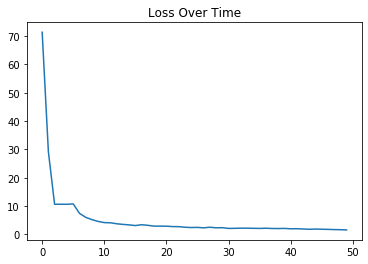

In [34]:
plt.plot(history.history["loss"][::10])
plt.title("Loss Over Time")
plt.show()